# Download dataset used in training

In [ ]:
#!curl http://www.eecs.qmul.ac.uk/~urm30/HairMaterial/Figaro-1k.zip -o Figaro-1k.zip

In [ ]:
#!unzip Figaro-1k.zip

# Use CPU for better debugging

In [ ]:
#import os
#os.environ.unsetenv("CUDA_LAUNCH_BLOCKING")

# Magic Functions/Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai.basics as fai
import fastai.vision as fv
import numpy as np
from pathlib import Path
import torch
import torch.nn.functional as F
import torch.nn as nn
import gc

# Dataloading

In [3]:
path_img = Path("Figaro-1k/Original/")
path_seg = Path("Figaro-1k/GT")

In [4]:
labels = (path_seg/"Training").ls()

In [5]:
codes = ["NoHair" for x in range(255)]
codes.append("Hair")

In [6]:
def imagen_segmentado(x):
    return path_seg/Path(str(x.relative_to(path_img))[:-7]+"gt.pbm")

def load_data(img_size, batch_size):
    tfms = fv.get_transforms()
    data = (fv.SegmentationItemList
            .from_folder(path_img)
            .split_by_folder(train="Training",valid="Testing")
            .label_from_func(imagen_segmentado, classes=codes)
            .transform(tfms, size=img_size, tfm_y=True)
            .databunch(bs=batch_size)
            .normalize(fv.imagenet_stats))
    return data

In [7]:
data = load_data(500,4)

In [ ]:
data.show_batch()

In [8]:
def acc_camvid(input, target):
    target = target.squeeze(1)

    return (input.argmax(dim=1) == target).float().mean()

In [9]:
learn = fv.unet_learner(data, fv.models.resnet34, metrics=acc_camvid, bottle=True)

# First Training Session

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5)

In [ ]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.show_results()

In [ ]:
learn.load("Model"); #Primer modelo 0.962

# Second Training Session

In [ ]:
whos

In [ ]:
learn.fit_one_cycle(5)

In [ ]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.show_results()

In [ ]:
learn.load("BestModel");

# Third Training Session

In [ ]:
learn.fit_one_cycle(10,3e-5)

In [ ]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.show_results()

In [10]:
learn.load("BestModel");

In [14]:
data = load_data(500,6)
learn.data = data

In [15]:
gc.collect()

56

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


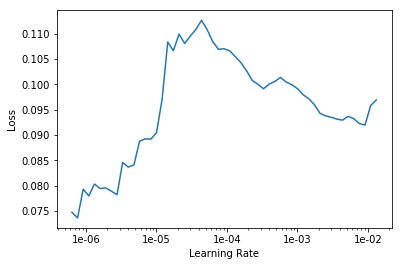

In [16]:
learn.lr_find(); learn.recorder.plot()

In [17]:
learn.fit_one_cycle(3,1e-6)

epoch,train_loss,valid_loss,acc_camvid
1,0.083855,0.075132,0.970773
2,0.084754,0.075391,0.970595
3,0.085329,0.074935,0.970782


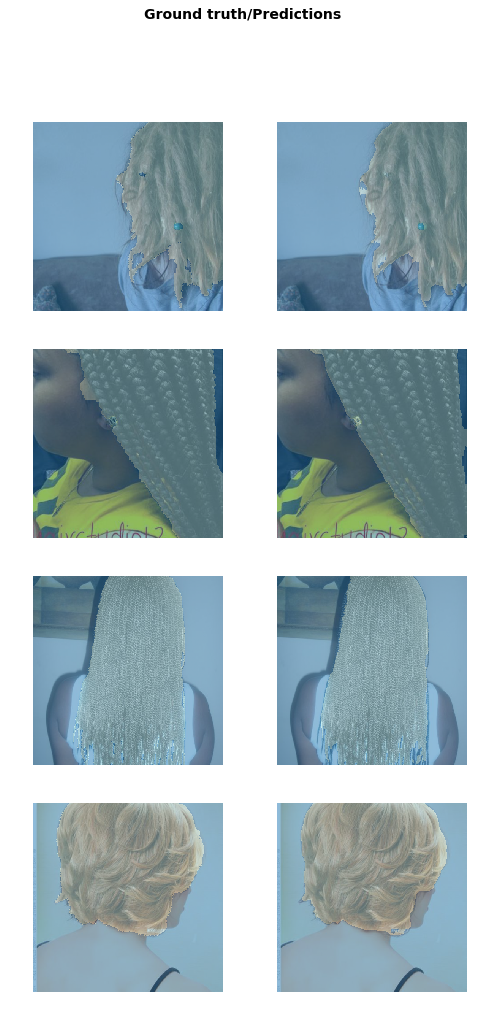

In [11]:
learn.show_results()

# Torch save and testing to deploy later

In [14]:
#torch.save(learn.model, "torchM")

In [15]:
fv.imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [21]:
loss = learn.loss_func

In [22]:
loss??

Signature:   loss(input: torch.Tensor, target: torch.Tensor, **kwargs) -> <function NewType.<locals>.new_type at 0x7fd58d399ea0>
Type:        FlattenedLoss
String form: FlattenedLoss of CrossEntropyLoss()
File:        /opt/anaconda3/lib/python3.7/site-packages/fastai/layers.py
Source:     
class FlattenedLoss():
    "Same as `func`, but flattens input and target."
    def __init__(self, func, *args, axis:int=-1, floatify:bool=False, is_2d:bool=True, **kwargs):
        self.func,self.axis,self.floatify,self.is_2d = func(*args,**kwargs),axis,floatify,is_2d

    def __repr__(self): return f"FlattenedLoss of {self.func}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        input = input.transpose(self.axis,-1).contiguous()
        target = target.transpose(self.axis,-1).contiguous()
        if self.floatify: target = tar

In [28]:
img = fv.open_image(path_img/"Testing/Frame00010-org.jpg")
img = learn.predict(img)

In [29]:
img

(ImageSegment (1, 500, 500), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]), tensor([[[9.3694e-01, 9.1998e-01, 9.4079e-01,  ..., 9.9826e-01,
           9.9683e-01, 9.9393e-01],
          [9.2963e-01, 9.1187e-01, 9.3008e-01,  ..., 9.9720e-01,
           9.9506e-01, 9.9139e-01],
          [9.4954e-01, 9.3391e-01, 9.3927e-01,  ..., 9.9806e-01,
           9.9754e-01, 9.9650e-01],
          ...,
          [9.9222e-01, 9.8612e-01, 9.8800e-01,  ..., 9.9902e-01,
           9.9864e-01, 9.9793e-01],
          [9.8589e-01, 9.7947e-01, 9.8665e-01,  ..., 9.9903e-01,
           9.9801e-01, 9.9619e-01],
          [9.7749e-01, 9.7127e-01, 9.8433e-01,  ..., 9.9890e-01,
           9.9717e-01, 9.9278e-01]],
 
         [[5.7084e-09, 8.0611e-09, 2.6804e-09,  ..., 9.7618e-17,
           5.9046e-16, 2.4747e-14],
          [6.2